# Loading words

In [518]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [519]:
len(words)

32033

In [520]:
min(len(w) for w in words)

2

In [521]:
max(len(w) for w in words)

15

# Creating Trigram

In [522]:
chars = sorted(list(set(''.join(words))))
ch2i = {ch: i + 1 for i, ch in enumerate(chars)}
ch2i['.'] = 0
i2ch = {v: k for k, v in ch2i.items()}
i2ch

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [523]:
import torch

N = torch.zeros((27, 27, 27), dtype=torch.int32)

for w in words:
    chs = ['.'] + list(w) + ['.']
    for chs1, chs2, chs3 in zip(chs, chs[1:], chs[2:]):
        ids1 = ch2i[chs1]
        ids2 = ch2i[chs2]
        ids3 = ch2i[chs3]
        N[ids1, ids2, ids3] += 1

# Flattening Trigram to 2-dimensional tensor (join 0 and 1 dimension) and Displaying Counts

In [524]:
N_trigram_flat = N.reshape(27*27, 27)
N_trigram_flat.shape

torch.Size([729, 27])

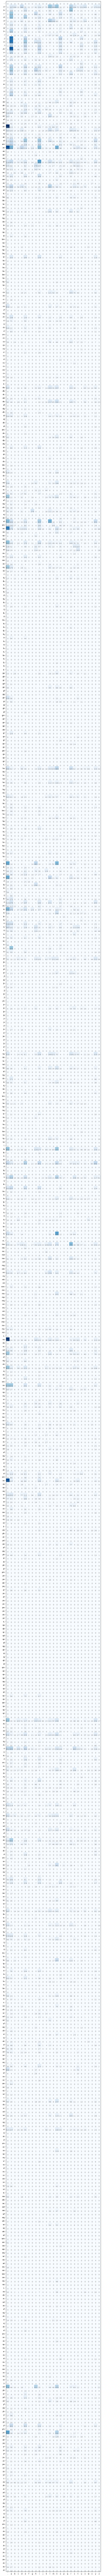

In [525]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 200))
plt.imshow(N_trigram_flat, cmap='Blues')
for i in range(N_trigram_flat.shape[0]):
    for j in range(N_trigram_flat.shape[1]):
        chstr = i2ch[i//27] + i2ch[i%27] + i2ch[j]
        plt.text(j, i, N[i//27, i%27, j].item(), ha='center', va='top', color='gray')

x_labels = [i2ch[j] for j in range(27)]
y_labels = [i2ch[i//27] + i2ch[i%27] for i in range(27 * 27)]

plt.xticks(ticks=list(range(27)), labels=x_labels)
plt.yticks(ticks=list(range(27*27)), labels=y_labels)
plt.tight_layout()
plt.show()

## Deleting Impossible Sequences
Those sequences that have '.' in the middle, e.g. ['...', 'a.a', 'b.a', ... ]

In [526]:
impossible_sequences = [f'{ch}.' for ch in sorted(ch2i.keys())]
impossible_sequences_ids = [i*27 for i in range(27)]
dict(zip(impossible_sequences, impossible_sequences_ids))

{'..': 0,
 'a.': 27,
 'b.': 54,
 'c.': 81,
 'd.': 108,
 'e.': 135,
 'f.': 162,
 'g.': 189,
 'h.': 216,
 'i.': 243,
 'j.': 270,
 'k.': 297,
 'l.': 324,
 'm.': 351,
 'n.': 378,
 'o.': 405,
 'p.': 432,
 'q.': 459,
 'r.': 486,
 's.': 513,
 't.': 540,
 'u.': 567,
 'v.': 594,
 'w.': 621,
 'x.': 648,
 'y.': 675,
 'z.': 702}

In [527]:
N_trigram_flat_possible = N_trigram_flat[[i for i in range(27*27) if i not in impossible_sequences_ids]]
N_trigram_flat_possible.shape

torch.Size([702, 27])

## Function to find the correct trigram index row after deletion

In [528]:
def row_idx(sequence_2: str) -> int:
    idx1, idx2 = ch2i[sequence_2[0]], ch2i[sequence_2[1]]
    idx_old = (idx1 * 27) + (idx2 % 27)
    idx_new = idx_old - len([l for l in impossible_sequences_ids if l < idx_old])
    return idx_new

In [529]:
print(f'Sequence: zyi')
print(f'Original Trigram Counts: {N[ch2i['z'], ch2i['y'], ch2i['i']].item()}')
print(f'N_trigram_flat Counts: {N_trigram_flat[(ch2i['z'] * 27) + (ch2i['y'] % 27), ch2i['i']]}')
print(f'N_trigram_flat_possible Counts: {N_trigram_flat_possible[row_idx('zy'), ch2i['i']]}')
print(f'Counts directly from all words: {len([w for w in words if 'zyi' in w])}')

Sequence: zyi
Original Trigram Counts: 12
N_trigram_flat Counts: 12
N_trigram_flat_possible Counts: 12
Counts directly from all words: 12


# Generating New Sequences based on Trigram Probabilities

## Converting Trigram Counts to Probabilities

In [530]:
P = (N_trigram_flat_possible + 1).float()
P /= P.sum(axis=1, keepdim=True)

In [531]:
P[0].sum()

tensor(1.0000)

## Calculating probabilities for starting sequences
Start sequences are sequences that begin with '.', e.g. ['.a', '.b', '.c.', ... ]

In [542]:
starting_ids = list(range(row_idx('aa')))  # all ids for starting sequences are lower than id for 'aa' sequence
P_start = N_trigram_flat_possible[starting_ids].float()
P_start = P_start.sum(axis=1)
P_start /= P_start.sum()

# Calculating Loss based on Trigram Probabilities

In [543]:
log_likelihood = 0
n = 0

for w in words:
    chs = ['.'] + list(w) + ['.']
    for chs1, chs2, chs3 in zip(chs, chs[1:], chs[2:]):
        sequence_id = row_idx(chs1 + chs2)
        prob = P[sequence_id, ch2i[chs3]]

        logprob = prob.log()
        log_likelihood += logprob
        n += 1

neg_log_likelihood = -log_likelihood
print(f'{log_likelihood=}')
print(f'{neg_log_likelihood=}')
print(f'{neg_log_likelihood/n=}')

log_likelihood=tensor(-410414.9688)
neg_log_likelihood=tensor(410414.9688)
neg_log_likelihood/n=tensor(2.0927)


## Testing New Sequences

In [544]:
g = torch.Generator().manual_seed(40)

for i in range(5):
    l = []
    
    start_id = torch.multinomial(P_start, num_samples=1, generator=g)
    sequence = '.' + i2ch[start_id.item() + 1]  # + 1 bcs we have deleted the first row
    l.append(sequence)

    while True:
        p = P[row_idx(sequence)]
        next_id = torch.multinomial(p, num_samples=1, generator=g).item()
        next_ch = i2ch[next_id]

        l.append(next_ch)
        sequence = sequence[1] + next_ch

        if next_id == 0:
            break

    print(''.join(l))

.mace.
.mirash.
.junzir.
.juseynn.
.eiya.


# Training Neural Network Model

## Splitting dataset into Train, Validation, Test Sets

In [545]:
X_full = []
y_full = []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        sequence = ch1 + ch2
        x_id = row_idx(sequence)
        y_id = ch2i[ch3]

        X_full.append(x_id)
        y_full.append(y_id)

X_full = torch.tensor(X_full)
y_full = torch.tensor(y_full)
        

In [546]:
split_1 = int(0.8 * len(X_full))
split_2 = int(0.9 * len(X_full))

X_train = X_full[:split_1]
y_train = y_full[:split_1]

X_valid = X_full[split_1:split_2]
y_valid = y_full[split_1:split_2]

X_test = X_full[split_2:]
y_test = y_full[split_2:]


In [547]:
print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

print(X_test.shape)
print(y_test.shape)

torch.Size([156890])
torch.Size([156890])
torch.Size([19611])
torch.Size([19611])
torch.Size([19612])
torch.Size([19612])


### One Hot Encoding X_train, X_valid and X_test set

In [551]:
import torch.nn.functional as F

X_train_enc = F.one_hot(X_train, num_classes=702).float()
X_valid_enc = F.one_hot(X_valid, num_classes=702).float()
X_test_enc = F.one_hot(X_test, num_classes=702).float()

## Testing model with random weights on several samples

In [552]:
import torch.nn.functional as F

g = torch.Generator().manual_seed(41)
W = torch.randn(N_trigram_flat_possible.shape, generator=g)

neg_log_likelihood = 0
nlls = torch.zeros(4)
for i in range(4):
    x = X_train[i]
    y = y_train[i]

    x_enc = X_train_enc[i]
    logits = x_enc.float() @ W
    counts = logits.exp()
    probs = counts / counts.sum()
    
    print('--------')
    print(f'bigram example {i+1}: {i2ch[x.item()//26] + i2ch[x.item()%26 + 1]} -> {i2ch[y.item()]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs)
    print('label (actual next character):', y)
    p = probs[y]
    print('probability assigned by the net to the the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e -> m (indexes 4,13)
input to the neural net: tensor(4)
output probabilities from the neural net: tensor([0.0714, 0.0473, 0.0075, 0.0122, 0.0329, 0.0266, 0.0079, 0.0122, 0.0254,
        0.0328, 0.0119, 0.0369, 0.0273, 0.0575, 0.1947, 0.0164, 0.0114, 0.0277,
        0.0493, 0.0370, 0.0120, 0.0112, 0.0212, 0.0175, 0.0468, 0.0815, 0.0636])
label (actual next character): tensor(13)
probability assigned by the net to the the correct character: 0.057457949966192245
log likelihood: -2.8567018508911133
negative log likelihood: 2.8567018508911133
--------
bigram example 2: em -> m (indexes 142,13)
input to the neural net: tensor(142)
output probabilities from the neural net: tensor([0.1224, 0.0809, 0.0185, 0.1110, 0.0558, 0.0475, 0.0188, 0.0105, 0.0049,
        0.0487, 0.0170, 0.0105, 0.0113, 0.0512, 0.0731, 0.0105, 0.0088, 0.0337,
        0.0197, 0.0049, 0.0824, 0.0241, 0.0075, 0.1023, 0.0032, 0.0075, 0.0130])
label (actual next character): tensor(13)
probability a

## Training Neural Net

In [602]:
g = torch.Generator().manual_seed(55)
W = torch.randn(N_trigram_flat_possible.shape, generator=g, requires_grad=True)

In [603]:
train_loss = []
valid_loss = []

for _ in range(600):   
    # Forward pass
    logits = X_train_enc @ W
    counts = logits.exp()
    probs = counts / counts.sum(axis=1, keepdim=True)
    
    # Train loss
    loss = -probs[torch.arange(logits.shape[0]), y_train].log().mean() + 0.001*(W**2).mean()
    train_loss.append(loss.item())

    # Model validation
    v_logits = X_valid_enc @ W
    v_counts = v_logits.exp()
    v_probs = v_counts / v_counts.sum(axis=1, keepdim=True)
    v_loss = -v_probs[torch.arange(v_logits.shape[0]), y_valid].log().mean()
    valid_loss.append(v_loss.item())
    
    # Results
    print(f'Trrain Loss: {loss}, Valid loss: {v_loss}')

    # Backward pass
    W.grad = None
    loss.backward()

    # Adjust weights
    W.data += -50 * W.grad

Trrain Loss: 3.785515308380127, Valid loss: 3.8079769611358643
Trrain Loss: 3.6981441974639893, Valid loss: 3.743159532546997
Trrain Loss: 3.61557674407959, Valid loss: 3.6821367740631104
Trrain Loss: 3.5377044677734375, Valid loss: 3.62467885017395
Trrain Loss: 3.4646477699279785, Valid loss: 3.570723295211792
Trrain Loss: 3.3966410160064697, Valid loss: 3.5202810764312744
Trrain Loss: 3.333892583847046, Valid loss: 3.4733567237854004
Trrain Loss: 3.2764453887939453, Valid loss: 3.42988657951355
Trrain Loss: 3.2241029739379883, Valid loss: 3.3897225856781006
Trrain Loss: 3.1764748096466064, Valid loss: 3.352659225463867
Trrain Loss: 3.1330862045288086, Valid loss: 3.3184731006622314
Trrain Loss: 3.093475103378296, Valid loss: 3.2869505882263184
Trrain Loss: 3.0572283267974854, Valid loss: 3.257896661758423
Trrain Loss: 3.0239856243133545, Valid loss: 3.231126546859741
Trrain Loss: 2.993424654006958, Valid loss: 3.2064599990844727
Trrain Loss: 2.96525239944458, Valid loss: 3.1837136745

### Plotting Results

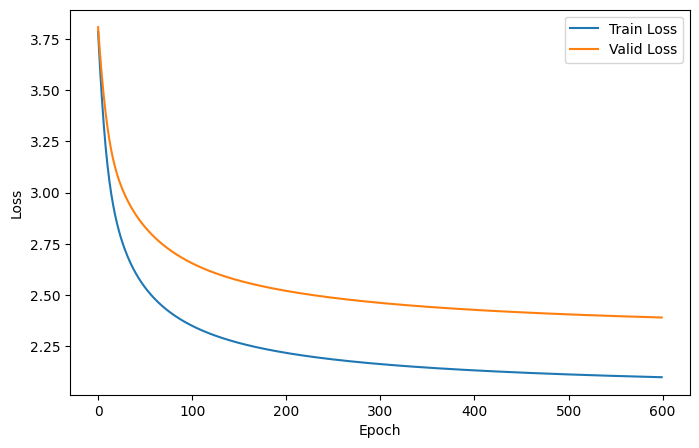

In [607]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Valid Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Tuning Model on concatenated Train and Valid set

In [614]:
X_conc_enc = torch.concatenate([X_train_enc, X_valid_enc], axis=0)
y_conc = torch.concatenate([y_train, y_valid], axis=0)

In [616]:
print(X_conc_enc.shape)
print(y_conc.shape)

torch.Size([176501, 702])
torch.Size([176501])


In [618]:
for _ in range(200):   
    # Forward pass
    logits = X_conc_enc @ W
    counts = logits.exp()
    probs = counts / counts.sum(axis=1, keepdim=True)
    
    # Train loss
    loss = -probs[torch.arange(logits.shape[0]), y_conc].log().mean() + 0.001*(W**2).mean()
    
    # Results
    print(f'Loss: {loss}')

    # Backward pass
    W.grad = None
    loss.backward()

    # Adjust weights
    W.data += -50 * W.grad

Loss: 2.117365837097168
Loss: 2.117267608642578
Loss: 2.1171696186065674
Loss: 2.1170718669891357
Loss: 2.1169745922088623
Loss: 2.116877317428589
Loss: 2.1167805194854736
Loss: 2.1166839599609375
Loss: 2.1165878772735596
Loss: 2.1164917945861816
Loss: 2.116396427154541
Loss: 2.1163010597229004
Loss: 2.116206169128418
Loss: 2.1161112785339355
Loss: 2.1160168647766113
Loss: 2.1159229278564453
Loss: 2.1158287525177
Loss: 2.1157355308532715
Loss: 2.1156423091888428
Loss: 2.115549087524414
Loss: 2.1154565811157227
Loss: 2.1153640747070312
Loss: 2.115271806716919
Loss: 2.1151797771453857
Loss: 2.11508846282959
Loss: 2.114997148513794
Loss: 2.114905834197998
Loss: 2.1148152351379395
Loss: 2.114724636077881
Loss: 2.1146345138549805
Loss: 2.11454439163208
Loss: 2.114454746246338
Loss: 2.114365339279175
Loss: 2.114276170730591
Loss: 2.114187240600586
Loss: 2.114098310470581
Loss: 2.1140100955963135
Loss: 2.113922119140625
Loss: 2.1138341426849365
Loss: 2.113746404647827
Loss: 2.1136586666107178

## Test Model on Test set

In [619]:
t_logits = X_test_enc @ W
t_counts = t_logits.exp()
t_probs = t_counts / t_counts.sum(axis=1, keepdim=True)
t_loss = -t_probs[torch.arange(t_logits.shape[0]), y_test].log().mean()
print(f'Test Loss: {t_loss}')

Test Loss: 2.3508880138397217


# Model inference

In [620]:
starting_ids = list(range(row_idx('aa')))  # all ids for starting sequences are lower than id for 'aa' sequence
P_start = N_trigram_flat_possible[starting_ids].float()
P_start = P_start.sum(axis=1)
P_start /= P_start.sum()

In [661]:
for i in range(10):
    l = []
    
    start_id = torch.multinomial(P_start, num_samples=1, generator=g)
    sequence = '.' + i2ch[start_id.item() + 1]
    l.append(sequence)

    while True:
        x_id = row_idx(sequence)
        x_enc = F.one_hot(torch.tensor([x_id]), num_classes=702).float()
        logits = x_enc @ W
        counts = logits.exp()
        p = counts / counts.sum(axis=1)

        next_id = torch.multinomial(p, num_samples=1, generator=g).item()
        next_ch = i2ch[next_id]

        l.append(next_ch)
        sequence = sequence[1] + next_ch

        if next_id == 0:
            break

    print(''.join(l))

.akhir.
.vanshri.
.na.
.vallee.
.kayceoran.
.anvea.
.wila.
.emriya.
.kai.
.deeigh.
